<a href="https://colab.research.google.com/github/spregler/Plant-Pathology-Capstone/blob/master/capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Environment

In [288]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [289]:
!pip install --upgrade --force-reinstall --no-deps kaggle

# set kaggle json dir
import os
#Personal example
os.environ['KAGGLE_CONFIG_DIR'] = "/project/.kaggle"
os.environ['KAGGLE_USERNAME'] = "spregler"
os.environ['KAGGLE_KEY'] = "e910c1636cfb935a5f3f382a1aefa24c"

Processing /root/.cache/pip/wheels/57/4e/e8/bb28d035162fb8f17f8ca5d42c3230e284c6aa565b42b72674/kaggle-1.5.6-cp36-none-any.whl
  Found existing installation: kaggle 1.5.6
    Uninstalling kaggle-1.5.6:
      Successfully uninstalled kaggle-1.5.6


In [290]:
%cd /project/

/project


In [0]:
!kaggle competitions download -c plant-pathology-2020-fgvc7

 98% 763M/779M [00:04<00:00, 228MB/s]
100% 779M/779M [00:04<00:00, 189MB/s]


In [0]:
!unzip plant-pathology-2020-fgvc7

In [291]:
!pip install "torch==1.4" "torchvision==0.5.0"

In [0]:
!pip install neptune-client
!pip install neptune-contrib
!pip install neptune-contrib[monitoring]

In [1]:
!pip install -I pandas==0.18.1 

     |████████████████████████████████| 7.3MB 7.7MB/s 
     |████████████████████████████████| 235kB 48.6MB/s 
     |████████████████████████████████| 512kB 48.4MB/s 
     |████████████████████████████████| 20.2MB 118kB/s 
  Created wheel for pandas: filename=pandas-0.18.1-cp36-cp36m-linux_x86_64.whl size=13855847 sha256=a386556ea567aa30037bd5f7717cbb95ad6025939b51b6e0cd3577ef34131fbb
  Stored in directory: /root/.cache/pip/wheels/a3/08/c3/8fdd52954d4b415624cff43c6dd32a22bac90306976a98f4af
Successfully built pandas
ERROR: xarray 0.15.1 has requirement pandas>=0.25, but you'll have pandas 0.18.1 which is incompatible.
ERROR: statsmodels 0.10.2 has requirement pandas>=0.19, but you'll have pandas 0.18.1 which is incompatible.
ERROR: seaborn 0.10.1 has requirement pandas>=0.22.0, but you'll have pandas 0.18.1 which is incompatible.
ERROR: plotnine 0.6.0 has requirement pandas>=0.25.0, but you'll have pandas 0.18.1 which is incompatible.
ERROR: pandas-profiling 1.4.1 has requirement pandas

# Import Dependencies & Extract Data

In [0]:
import neptune

neptune.init(
    api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiMTA3NjRiMTQtMWM0MS00YmVjLTliYzAtMzYwYWJkNmNlY2IyIn0=',
    project_qualified_name='spregler/fastai'
)

Project(spregler/fastai)

In [293]:
import os 
from pathlib import Path

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import fastai
import fastai.vision
from fastai import *
from fastai.vision import *
from fastai.vision import learner
from sklearn.metrics import *

import pandas as pd
import numpy as np

root_dir = Path("/project/") # Local path object in colab
train_df = pd.read_csv('/project/train.csv')
test_df = pd.read_csv("/project/test.csv")
train_df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


# Transform Data w/ Helper Function

In [0]:
def transformPipeline(df):
  # Creates a class column and assign it to the index which produces the max value for each row
  df['class'] = np.argmax(train_df.loc[:, ['healthy','multiple_diseases','rust','scab']].values, axis=1)
  # Drops columnns that are no longer of use
  df.drop(columns=['healthy','multiple_diseases','rust','scab'], inplace=True)
  print("Transformed df: ")
  print(train_df.head())


In [295]:
transformPipeline(train_df)

Transformed df: 
  image_id  class
0  Train_0      3
1  Train_1      1
2  Train_2      0
3  Train_3      2
4  Train_4      0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa9a0697908>]], dtype=object)

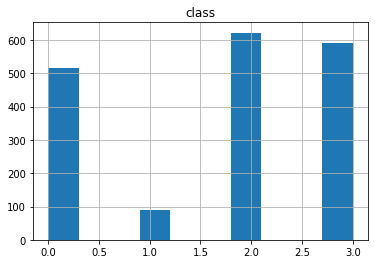

In [296]:
train_df.hist() # we have imbalanced data!

In [297]:
train_df['class'].value_counts(sort=False)

0    516
1     91
2    622
3    592
Name: class, dtype: int64

# Create ImageList Object Using DataBlocks API

In [0]:
np.random.seed(42)
src = (ImageList.from_df(train_df, root_dir, folder='images', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df()
       .add_test(test_data))

tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.5, max_rotate=90.0)

data = (src.transform(tfms, size=224)
      .databunch(bs=64)
      .normalize(imagenet_stats))

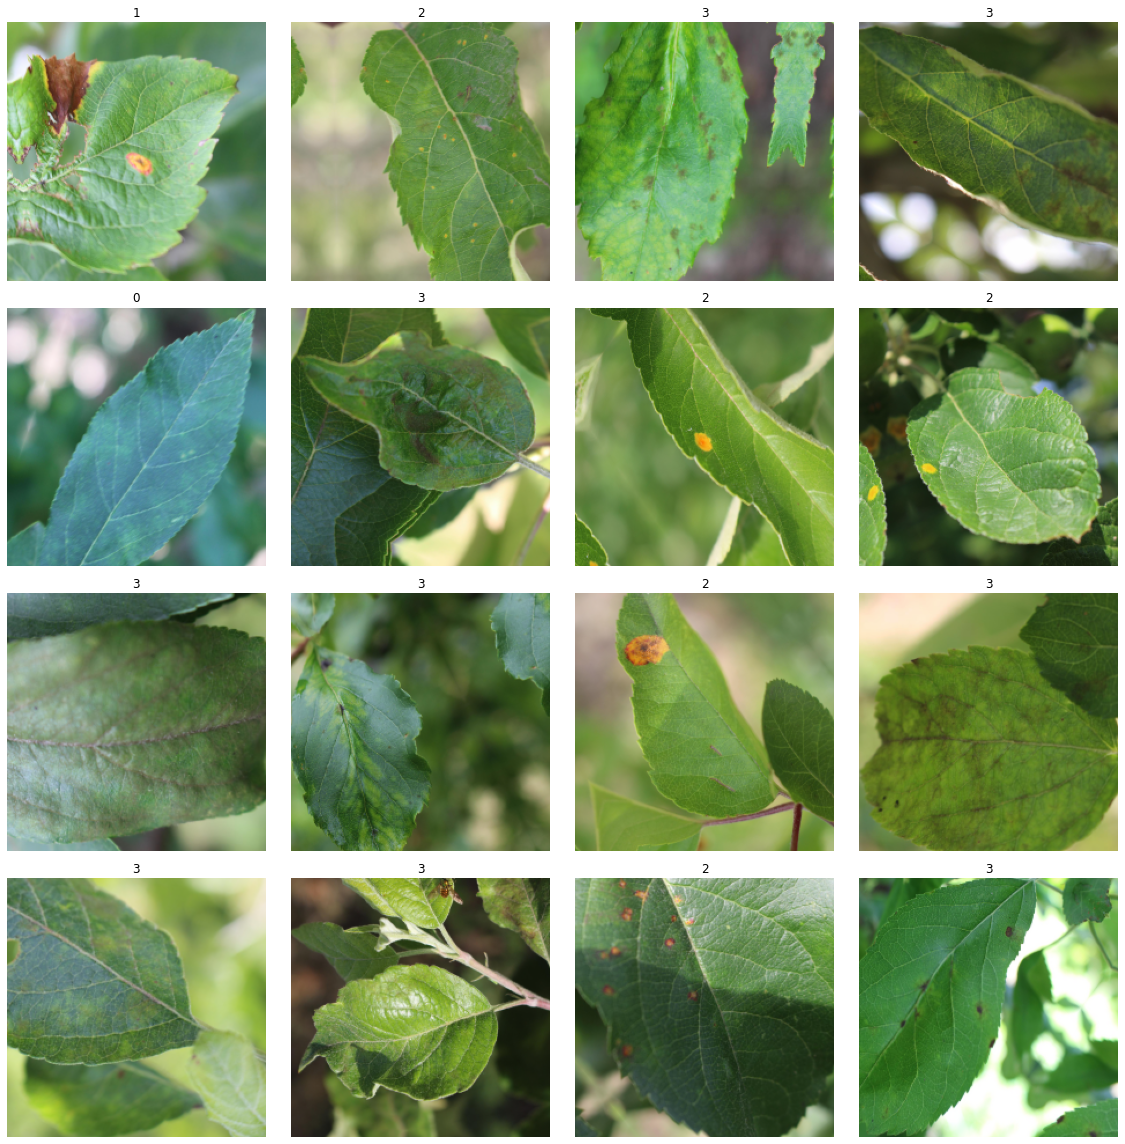

In [299]:
data.show_batch(rows=4)

# Training

The following cell integrates the Neptune API with the Fastai framework. Neptune is an experiment management tool that is helpful for keeping track of experiments and logging metrics.

In [302]:
from fastai.callbacks import *
from neptunecontrib.monitoring.fastai import NeptuneMonitor

arch = models.resnet50 # define model

with neptune.create_experiment(params={'lr':1e-3}):
  learn = cnn_learner(data, arch, metrics=[accuracy , error_rate],
                        callback_fns=[NeptuneMonitor], wd=1e-3).to_fp32()
  learn.fit_one_cycle(5, 1e-3) # fit to our data

https://ui.neptune.ai/spregler/fastai/e/FAS-26


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.511626,0.534382,0.854396,0.145604,02:13
1,1.017200,0.457798,0.865385,0.134615,02:10
2,0.772156,0.430373,0.868132,0.131868,02:10
3,0.609540,0.371349,0.887363,0.112637,02:12
4,0.516886,0.343809,0.890110,0.109890,02:16


https://ui.neptune.ai/spregler/fastai/e/FAS-29


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.45E-05
Min loss divided by 10: 3.98E-05


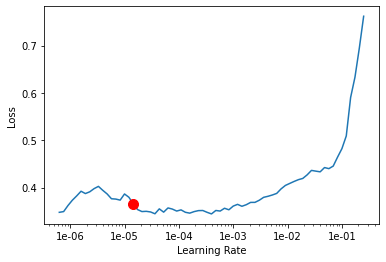

In [307]:
with neptune.create_experiment():
  learn.lr_find() # find optimal lr
  learn.recorder.plot(suggestion=True)

In [0]:
learn.save('resnet50-stage0')
learn.load('resnet50-stage0')
learn.unfreeze()

In [310]:
with neptune.create_experiment():
  learn.fit_one_cycle(10, slice(1.45e-05,3.98e-04))

https://ui.neptune.ai/spregler/fastai/e/FAS-31


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.365085,0.315703,0.906593,0.093407,02:15
1,0.343638,0.261005,0.920330,0.079670,02:15
2,0.314541,0.326141,0.914835,0.085165,02:15
3,0.289954,0.348528,0.906593,0.093407,02:15
4,0.265114,0.215933,0.934066,0.065934,02:14
5,0.228249,0.195087,0.936813,0.063187,02:15
6,0.206983,0.236886,0.923077,0.076923,02:15
7,0.185290,0.205349,0.942308,0.057692,02:17
8,0.175291,0.200808,0.947802,0.052198,02:16
9,0.159773,0.198956,0.945055,0.054945,02:15


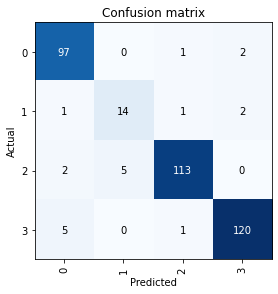

In [311]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

356 misclassified samples over 364 samples in the validation set.


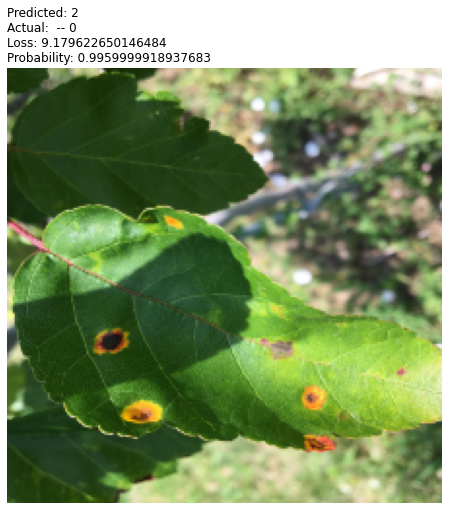

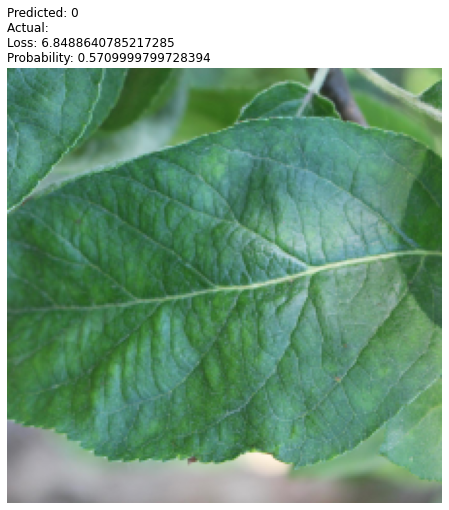

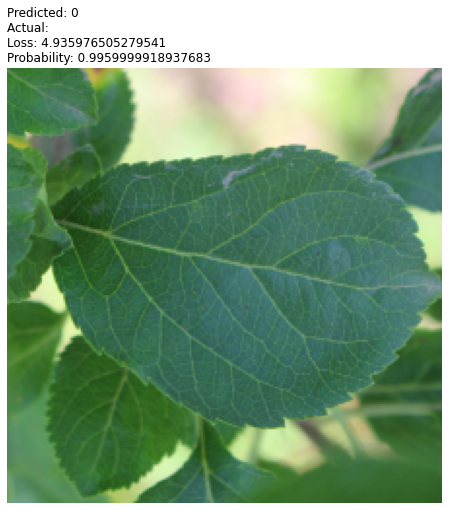

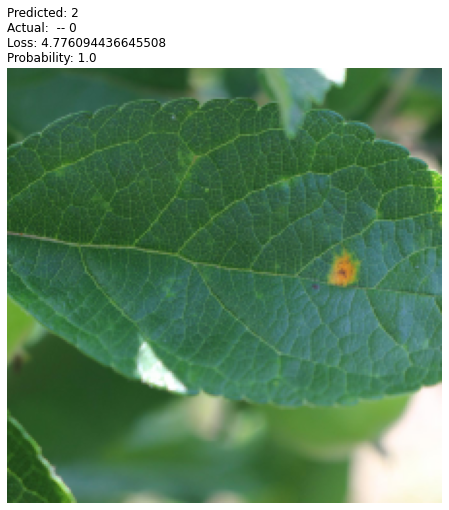

In [312]:
interp.plot_multi_top_losses(samples=4)

In [314]:
learn.save('resnet50-stage1')
learn.load('resnet50-stage1')

Learner(data=ImageDataBunch;

Train: LabelList (1457 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
3,1,0,2,0
Path: /project;

Valid: LabelList (364 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
2,0,0,2,0
Path: /project;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(

In [0]:
learn = load_learner(root_dir, test=test_data)

# Inference


In [339]:
preds, y = learn.get_preds(DatasetType.Test)

In [347]:
preds.numpy()

array([[9.999816e-01, 1.832170e-05],
       [9.652424e-01, 3.475760e-02],
       [9.992667e-01, 7.332586e-04],
       [1.662594e-07, 9.999999e-01],
       ...,
       [9.479861e-01, 5.201381e-02],
       [9.947189e-01, 5.281068e-03],
       [3.196846e-07, 9.999996e-01],
       [9.924943e-01, 7.505656e-03]], dtype=float32)

# Kaggle Competition Stuff




In [348]:
sample_df = pd.read_csv(root_dir/'sample_submission.csv')
sample_df.iloc[:,1] = preds.numpy()
sample_df.to_csv('submission.csv', index=False)

ValueError: ignored

In [0]:
import pickle 
learner.export() # Save model for inference to export.pkl

# Conclusion:
The end model was able to acheive a score of .922 on the kaggle challenge learderboard: https://www.kaggle.com/c/plant-pathology-2020-fgvc7/leaderboard

Just by tuning a ResNet50, we were able to acheive an accuracy of 0.975.

The origninal paper outlining this challenge can be found: https://arxiv.org/abs/2004.11958